In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import combinations_with_replacement, combinations
import libpysal.weights as lpw

/Users/yeonsoo/Documents/Research/RA-May2023/SARvenv/lib/python3.11/site-packages/libpysal/weights/util.py:23: UserWarning: geopandas not available. Some functionality will be disabled.
  warn("geopandas not available. Some functionality will be disabled.")


In [2]:
# set seed
seed_value = 42
np.random.seed(seed_value)

In [3]:
# coordinates function
def make_coords(N_points, xm, xM, ym, yM):
    
    # Define the range of coordinate values
    xmin, ymin = xm, ym
    xmax, ymax = xM, yM
    
    x_coords = np.random.uniform(xmin, xmax, size=N_points)
    y_coords = np.random.uniform(ymin, ymax, size=N_points)
    coords = np.column_stack((x_coords, y_coords))
    return coords
    

In [4]:
# make coordinates
N = 20
coords = make_coords(N, 0, 10, 0, 10)

# 1. Generate $Y$

$$ y = (I-\rho W)^{-1}v $$


In [5]:
# calculate inverse matrix A
# function that makes weight matrix
def make_weight(coords, thres):
    w = lpw.DistanceBand.from_array(coords, threshold=thres, binary=True)
    w.transform = 'R'
    return w.full()[0]


# function that checks if the matrix is invertible
def check_invertible(matrix):
    try:
        inverse = np.linalg.inv(matrix)
        return inverse
    except np.linalg.LinAlgError:
        return False

    
# function that calculates A
def get_A(coords, N, thres, rho):
    
    # make weight matrix
    W = make_weight(coords, thres)
    
    # calculate (I - rho * W)
    I = np.identity(N)
    X = I - rho * W
    
    # get A
    A = check_invertible(X)
    
    return A

In [6]:
# simulation
# set up parameters
n = 1000
threshold = 5
rho = 0.5 

# calculate invertible matrix A
A = get_A(coords, N, threshold, rho)

results = [] # generated n * y = [y1, y2, ..., yN]
V = [] # randomly generated v = [v1, v2, ..., vD], (D = N)

# run simulations
for i in range(n):
    # Generate random v from standard normal distribution
    v = np.random.randn(N, 1) 
    V.append(v)
    # Compute the matrix product
    y = np.dot(A, v) # y = N x 1 vector
    results.append(y)
    
    # if i % 10 == 0:
    #     print(f"Iteration: {i+1} / {n}")
    #     print("The shape of the simulation result is: ", np.shape(results))


print("The shape of the simulation result is: ", np.shape(results)) # (n, N, 1), cf. 3D array

The shape of the simulation result is:  (1000, 20, 1)


In [7]:
# convert results into dataframe (n, N) 
# make a column names list; y1, y2, ..
col_names = []

for i in range(N):
    col_names.append('y{}'.format(i+1))

simul_df = pd.DataFrame(np.reshape(results, (n, N)), columns=col_names)

# 2. Get Calculated Covariance
## 2-1.  Calculate covariance of generated y

In [9]:
# calculate covariance of generated y
cov_cal = np.cov(simul_df.T)
cov_cal = pd.DataFrame(cov_cal, columns=col_names, index=col_names)

## 2-2. Plot Calculated Covariance - Ditsances

In [10]:
# distance matrix
# initialize an empty distances matrix
distances = np.zeros((N, N))

# compute the euclidean distance between pair of coords
for i in range(N):
    for j in range(i+1, N):
        distances[i,j] = distances[j,i] = np.linalg.norm(coords[i] - coords[j])    

# convert distances to dataframe
distances = pd.DataFrame(distances, columns=col_names, index=col_names)

In [11]:
# make pairs of yi, yj
column_pairs = list(combinations(col_names, 2))

# make covaraince & distance paris of yi, yj
dis_pairs = [(distances[yi][yj]) for yi, yj in column_pairs]
cov_cal_pairs = [(cov_cal[yi][yj]) for yi, yj in column_pairs]

cal_dis_df = pd.DataFrame({'Calculated Covariance':cov_cal_pairs, 'Distances': dis_pairs}, index=column_pairs)

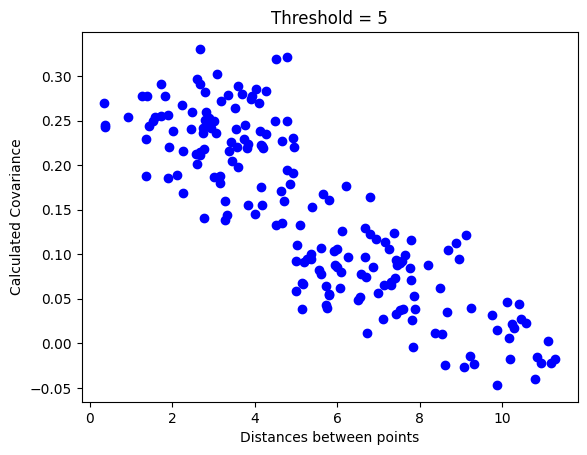

In [12]:
# plotting
plt.scatter(cal_dis_df['Distances'], cal_dis_df['Calculated Covariance'], c='blue')
# plt.yscale('log')
plt.ylabel('Calculated Covariance')
plt.xlabel('Distances between points')
plt.title('Threshold = ' + str(threshold))
plt.show()

# 3. Covariance Model
## 3-1. Get covariance using covariance model derived from SAR 
$$ Cov(Y_i, Y_j|X_i, X_j) = \sigma^2 \Sigma_{k}A_{ik}A_{jk}$$

In [13]:
# calculate covariance between yi & yj
# get variance of vector V; sigma^2
var = np.var(V) # sigma^2

# initialize an empty covariance matrix
cov_model = np.zeros((N, N))


for i in range(N):
  for k in range(N):
    for j in range(N):
      cov_model[i,k] += A[i,j] * A[k,j]
      cov_model[k,i] += A[i,j] * A[k,j]

cov_model = var * cov_model / 2

# convert results to dataframe
cov_model = pd.DataFrame(cov_model, columns=col_names, index=col_names)

## 3-2. Plot Covariance model - Distances

In [14]:
# get modeled covariance of pairs of yi, yj
cov_model_pairs = [(cov_model[yi][yj]) for yi, yj in column_pairs]

model_dis_df = pd.DataFrame({'Covariance Model': cov_model_pairs, 'Distances': dis_pairs}, index=column_pairs)

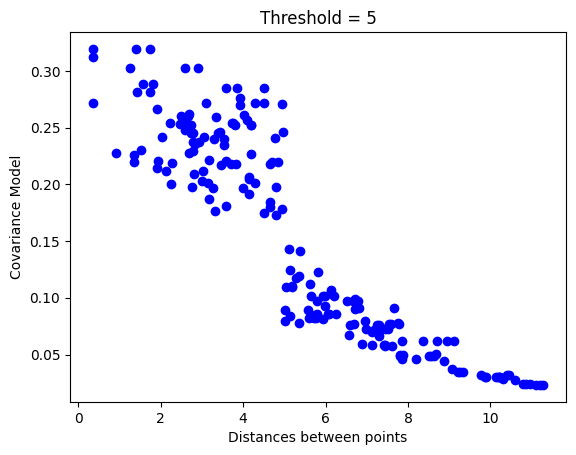

In [15]:
# plotting
plt.scatter(model_dis_df['Distances'], model_dis_df['Covariance Model'], c='blue')
# plt.yscale('log')
plt.ylabel('Covariance Model')
plt.xlabel('Distances between points')
plt.title('Threshold = ' + str(threshold))
plt.show()